In [2]:
import numpy as np 
import scipy
from scipy.stats import ncx2, fisher_exact
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm 

%matplotlib inline

# Evaluating Power for Standard Quantitative Traits Under a simple Linear Regression Model

In [13]:
def llr_power(alpha,df,ncp):
    """Power of asymptotic log-likelihood ratio test for a quantitative trait."""
    return 1. - ncx2.cdf(ncx2.ppf(1.-alpha, df, 0), df, ncp)

def qtl_assoc_power(n=100, p=0.1, beta=0.1, r2=1.0, alpha=0.05):
    """Quantitative association power assuming HWE.  
       NOTE: we are assuming the HWE model from Visscher et al. 
    """
    ncp = n * r2 * 2*p *(1.-p) * (beta**2)
    return llr_power(alpha, df=1, ncp=ncp)

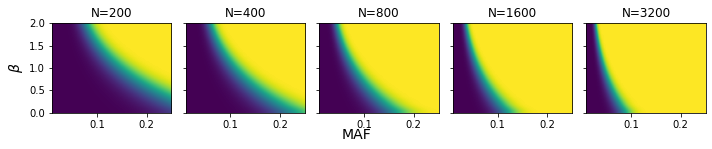

In [15]:
ns = [200, 400, 800, 1600, 3200]
ps = np.logspace(-2, np.log10(0.25), 20)
beta = np.linspace(0, 2, 50)

extent = [np.min(ps) , np.max(ps), np.min(beta) , np.max(beta)]

fig, ax = plt.subplots(1,len(ns),figsize=(2*len(ns),2), sharex=True, sharey=True)

for k,n in enumerate(ns):
    Z = np.zeros(shape=(ps.size, beta.size))
    for i,p in enumerate(ps):
        for j,b in enumerate(beta):
            Z[i,j] = qtl_assoc_power(n=ns[k], p=p, beta=b, r2=0.8, alpha=1e-5)
    ax[k].imshow(Z, origin="lower", extent=extent, aspect='auto', interpolation='lanczos')
    ax[k].set_title(f'N={n}', fontsize=12)


ax[0].set_ylabel(r'$\beta$', fontsize=14)
fig.text(0.5, -0.01, 'MAF', fontsize=14, va='bottom', ha='center')
plt.tight_layout()
plt.savefig('../plots/power_sample_size_qtl_mapping.pdf', bbox_inches='tight')

In [17]:
# def power_pqtl_study(n=100, p=0.1, beta=0.1, r2=1.0, alpha=0.05):
#     """Calculating power in a pQTL study."""
#     ncp = n*r2*(1. - (2*p*(1-p)*(beta**2))) / (2*p*(1-p)*(beta**2))
#     ncp_alt = n * r2 * p *(1.-p) * (beta**2)
#     print(p, ncp, ncp_alt)
#     return llr_power(alpha, 1, ncp=ncp)


# n = 1600
# ps = np.logspace(-2, np.log10(0.25), 20)
# beta = 1.0

# fig, ax = plt.subplots(1,1, figsize=(5,5))
# power = [power_pqtl_study(n=n, p=p, beta=1.0, alpha=1e-5) for p in ps]
# print(power)

# ax.set_ylabel(r'$\beta$', fontsize=14)
# ax.set_xlabel(r'MAF')
# plt.tight_layout()

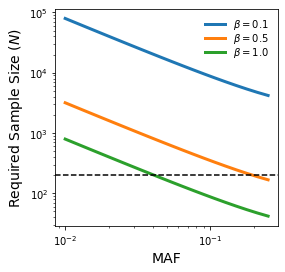

In [116]:
from scipy.optimize import root_scalar
# Determine sample-size required for 80% power 

def determine_ess(beta=0.1, maf=0.1, power=0.8, r2=1.0, alpha=0.05):
    f = lambda n: qtl_assoc_power(n, p=maf, beta=beta, r2=r2, alpha=0.05) - power
    res = root_scalar(f, bracket=(0,1e6))
    return res.root

fig, ax = plt.subplots(1,1, figsize=(4,4))
for b in [0.1,0.5,1.0]:
    ess1 = [determine_ess(beta=b, maf=x) for x in ps]
    ax.loglog(ps, ess1, lw=3, label=r'$\beta = {}$'.format(b))

ax.axhline(y=200, linestyle='--', color='black')    

ax.legend(frameon=False, labelspacing=0.0)
ax.set_xlabel(r'MAF', fontsize=14)
ax.set_ylabel(r'Required Sample Size ($N$)', fontsize=14);
plt.savefig('../plots/required_sample_size.80percent_power.pdf', bbox_inches='tight')

In [50]:
# Extreme Phenotype Study Design
def sim_extreme_pheno(n=100, maf=0.01, beta=0.1, seed=42):
    np.random.seed(seed)
    allele_count = np.random.binomial(2, maf, size=n)
    phenotype = np.random.normal(size=n) + beta*allele_count
    return allele_count, phenotype


def est_power_extreme_pheno(n=100, maf=0.01, beta=0.1, niter=100, alpha=0.05, q0=0.1, q1=0.1):
    """Estimate the power from an extreme-phenotype sampling design."""
    assert niter > 0
    n_reject = 0 
    for i in range(niter):
        ac, phenotype = sim_extreme_pheno(n=n, maf=maf, beta=beta, seed=i)
        excontrols = (phenotype <= np.quantile(phenotype, q0)) #bottom percentiles
        excases = (phenotype >= np.quantile(phenotype,1-q1)) #top-percentiles
        table = np.array([[np.sum(ac[excases]), 2*np.sum(excases) - np.sum(ac[excases])], [np.sum(ac[excontrols]), 2*np.sum(excontrols) - np.sum(ac[excontrols])]])
        odds_ratio, pval = fisher_exact(table)
        n_reject += (pval < alpha)
    return n_reject/niter

ext_pheno_power_b1 = [est_power_extreme_pheno(n=200, beta=0.1, maf=p, niter=500) for p in tqdm(ps)]
ext_pheno_power_b2 = [est_power_extreme_pheno(n=200, beta=0.5, maf=p, niter=500) for p in tqdm(ps)]
ext_pheno_power_b3 = [est_power_extreme_pheno(n=200, beta=1.0, maf=p, niter=500) for p in tqdm(ps)]

100%|██████████████████████████████████████████████████████████| 30/30 [01:33<00:00,  3.12s/it]


In [85]:
def est_power_extreme_pheno_maf_interpolate(mafs, nbisect=5, **kwargs):
    """Approximate the function using simulations to seed interpolation."""
    assert nbisect > 2
    min_maf = np.min(mafs)
    max_maf = np.max(mafs)
    power = []
    maf_seed = []
    # maf_seed.append(min_maf)
    # power.append(est_power_extreme_pheno(maf=min_maf, **kwargs))
    # maf_seed.append(max_maf)
    # power.append(est_power_extreme_pheno(maf=max_maf, **kwargs))
    for i in np.logspace(np.log10(min_maf), np.log10(max_maf), nbisect):
        maf_seed.append(i)
        power.append(est_power_extreme_pheno(maf=i, **kwargs))
    return np.array(maf_seed), np.array(power)

%time est_power_extreme_pheno_maf_interpolate(ps, nbisect=6, n=500, beta=0.5, niter=500)

CPU times: user 12.2 s, sys: 0 ns, total: 12.2 s
Wall time: 12.2 s


(array([0.01      , 0.01903654, 0.03623898, 0.06898648, 0.13132639,
        0.25      ]),
 array([0.01 , 0.138, 0.42 , 0.81 , 0.974, 1.   ]))

In [108]:
ps = np.logspace(-2, np.log10(0.25), 20)
beta = np.linspace(0, 2, 20)

Z1 = np.zeros(shape=(ps.size, beta.size))
# for i,p in tqdm(enumerate(ps)):
for j,b in tqdm(enumerate(beta)):
    mafs, powers = est_power_extreme_pheno_maf_interpolate(ps, nbisect=6, n=1000, beta=b, alpha=1e-5, q0=0.1, q1=0.1, niter=200) 
    f = interp1d(mafs, powers, fill_value=(0, 1.), kind='slinear')
    Z1[:,j] = f(ps)
            

Z = np.zeros(shape=(ps.size, beta.size))
for i,p in tqdm(enumerate(ps)):
    for j,b in enumerate(beta):
        Z[i,j] = qtl_assoc_power(n=1000, p=p, beta=b, r2=1.0, alpha=1e-5)

20it [03:43, 11.16s/it]
20it [00:00, 52.84it/s]


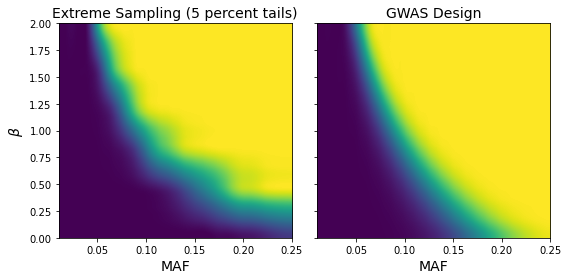

In [114]:
# Plotting differences in power between the two and interpolating 
fig, ax = plt.subplots(1,2,figsize=(8,4), sharey=True, sharex=True)
ax[0].imshow(Z1, origin="lower", extent=extent, aspect='auto', interpolation='lanczos')
im = ax[1].imshow(Z, origin="lower", extent=extent, aspect='auto', interpolation='lanczos')
ax[0].set_ylabel(r'$\beta$', fontsize=14);
ax[0].set_xlabel('MAF', fontsize=14);
ax[1].set_xlabel('MAF', fontsize=14);
ax[0].set_title(r'Extreme Sampling (5 percent tails)', fontsize=14)
ax[1].set_title(r'GWAS Design', fontsize=14)
plt.tight_layout()
plt.savefig('../plots/extreme_sampling_n1000_5percent.pdf', bbox_inches='tight')